<h1>Text Analytics for Health -  Assignment 2A <br></h1>
Student Name and ID: Jule Valendo Halim - 1425567 

Data: mtsamples.csv

In [1]:
## IMPORTS

import nltk
import string
import pandas as pd
import numpy as np
import spacy
import medspacy
import warnings
import matplotlib.pyplot as plt
import seaborn
from collections import Counter
from medspacy.ner import TargetRule
from medspacy.visualization import visualize_ent, visualize_dep
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay

## DOWNLOADS
# !python -m spacy download en_core_web_sm
# nltk.download('stopwords')
# nltk.download('punkt')

In [2]:
##Question 1
path='./mtsamples.csv'
df=pd.read_csv(path,index_col=0)
cleanedData=df.dropna(subset=['transcription'])
print('Numbers of rows after filtering out empty transcription:',len(cleanedData.index))

Numbers of rows after filtering out empty transcription: 4966


# Question 1 Response #

Numbers of rows after filtering out empty transcription: 4966

<Axes: xlabel='Count', ylabel='Medical Specialty'>

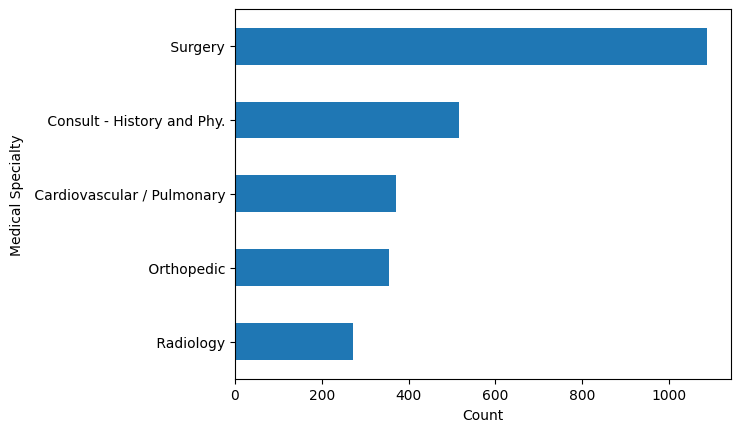

In [3]:
## Question 2

topSpecialties=cleanedData['medical_specialty'].value_counts().head(5)
topSpecialties=topSpecialties.iloc[::-1]
topSpecialties.plot(kind='barh',xlabel="Count",ylabel="Medical Specialty")

In [4]:
## Question 3

surgery=cleanedData[cleanedData['medical_specialty'] == ' Surgery']['transcription'].tolist()

allBigrams=[]
for doc in surgery:
    tokens=nltk.word_tokenize(doc)
    tg=nltk.ngrams(tokens,n=2)
    allBigrams.extend(list(tg))
    
print('--Direct Bigrams--')
for i in (Counter(allBigrams).most_common(5)):
    print(i)

stopwords=nltk.corpus.stopwords.words('english')
punkt=string.punctuation

# allBigrams=[]
# for doc in surgery:
#     tokens=nltk.word_tokenize(doc)
#     tokens=[t for t in tokens if t.lower() not in punkt and t.lower()]
#     tg=nltk.ngrams(tokens,n=2)
#     allBigrams.extend(list(tg))
    
# print('--Punctuation Removed Bigrams--')
# for i in (Counter(allBigrams).most_common(5)):
#     print(i)

# allBigrams=[]
# for doc in surgery:
#     tokens=nltk.word_tokenize(doc)
#     tokens=[t for t in tokens if t.lower() not in stopwords]
#     tg=nltk.ngrams(tokens,n=2)
#     allBigrams.extend(list(tg))
    
# print('--Stopword Removed Bigrams--')
# for i in (Counter(allBigrams).most_common(5)):
#     print(i)
    
allBigrams=[]
for doc in surgery:
    tokens=nltk.word_tokenize(doc)
    tokens=[t for t in tokens if t.lower() not in stopwords and t.lower() not in punkt]
    tg=nltk.ngrams(tokens,n=2)
    allBigrams.extend(list(tg))   
    
print('--Punctuation and Stopword Removed Bigrams--')
for i in (Counter(allBigrams).most_common(5)):
    print(i)


## The direct bigrams doesn't show very informative bigrams, and they mostly contain common words/punctuations as opposed to anything specific that could indicate diagnoses
## On the other hand, the ones with removed stopwords and punctuations show bigrams that are more in the context of the medical field

--Direct Bigrams--
(('.', 'The'), 9740)
((':', ','), 6081)
(('of', 'the'), 5886)
(('to', 'the'), 4325)
(('in', 'the'), 3472)
--Punctuation and Stopword Removed Bigrams--
(('prepped', 'draped'), 692)
(('operating', 'room'), 670)
(('PREOPERATIVE', 'DIAGNOSIS'), 551)
(('POSTOPERATIVE', 'DIAGNOSIS'), 515)
(('tolerated', 'procedure'), 510)


# Question 3 Response #

The direct bigrams doesn't show very informative bigrams, and they mostly contain common words/punctuations as opposed to anything specific that could indicate diagnoses.
On the other hand, the ones with removed stopwords and punctuations show bigrams that are more in the context of the medical field. Generally, the bigrams are related to the surgery area.

In [5]:
## Question 4

radiology=cleanedData[(cleanedData['medical_specialty']==' Radiology')]['transcription'].tolist()[:5]

def obtainSentencesNLTK(document):
    print('NLTK OUTPUT:')
    n=0
    for text in document:
        sentences=nltk.sent_tokenize(text)
        n+=1
        for i, sentence in enumerate(sentences):
            print('Document',n,'Sentence',i+1,sentence)
            
obtainSentencesNLTK(radiology)

NLTK OUTPUT:
Document 1 Sentence 1 EXAM: , Ultrasound examination of the scrotum.,REASON FOR EXAM: , Scrotal pain.,FINDINGS:  ,Duplex and color flow imaging as well as real time gray-scale imaging of the scrotum and testicles was performed.
Document 1 Sentence 2 The left testicle measures 5.1 x 2.8 x 3.0 cm.
Document 1 Sentence 3 There is no evidence of intratesticular masses.
Document 1 Sentence 4 There is normal Doppler blood flow.
Document 1 Sentence 5 The left epididymis has an unremarkable appearance.
Document 1 Sentence 6 There is a trace hydrocele.,The right testicle measures 5.3 x 2.4 x 3.2 cm.
Document 1 Sentence 7 The epididymis has normal appearance.
Document 1 Sentence 8 There is a trace hydrocele.
Document 1 Sentence 9 No intratesticular masses or torsion is identified.
Document 1 Sentence 10 There is no significant scrotal wall thickening.,IMPRESSION:  ,Trace bilateral hydroceles, which are nonspecific, otherwise unremarkable examination.
Document 2 Sentence 1 EXAM: , Two

# Question 4 Response #

I think generally, it does identify sentences correctly but not always. For example, 'There is a trace hydrocele.,The right testicle measures 5.3 x 2.4 x 3.2 cm.' is two sentences but it was read as one. This could be due to how punctuations of '.,' are not considered sentence ending compared to just a period sign('.'). Other similar combinations of punctuations could also result in erroneous sentence divisions. 

In [6]:
## Question 5

twoDocumentRadiology=cleanedData[(cleanedData['medical_specialty']==' Radiology')]['transcription'].tolist()[:2]
#nlp_med=medspacy.load('en_roberta_clinical_ner_1')
nlp_med=medspacy.load(medspacy_enable=['medspacy_pyrush'])
nlp=spacy.load('en_core_web_sm')
print('SPACY OUTPUT:')
n=0
for text in twoDocumentRadiology:
    n+=1
    documentSpacy=nlp(text)
    for i,sentence in enumerate(documentSpacy.sents):
        print('Document',n,'Sentence',i+1,sentence)
        
#ANATOMY,OBSERVATION UNCERTAIN, OBSERVATION PRESENT, OBSERVATION ABSENT
targetRules=[
    ## ANATOMY Target Rules
    ## Generally, anatomy consists of body parts that are noted.
    TargetRule(literal='scrotum',category='ANATOMY'), # scrotum is a part of the body if present, would indicate some anatomical examination
    TargetRule('scrotal wall','ANATOMY'), # a part of the scrotum and anatomy
    TargetRule('testicles','ANATOMY'), # testicle is a part of the body and if present would show some anatomical examination
    TargetRule('testicle','ANATOMY'), # Same as testicle, just plural
    TargetRule('epididymis','ANATOMY'), # a part of the anatomical structure
    TargetRule('tonsils','ANATOMY'), # part of the throat and anatomical structure
    TargetRule('trachea','ANATOMY'), #part of the throat
    TargetRule('adenoids','ANATOMY'), # tissue at the back of the nasal passage
    TargetRule('neck','ANATOMY'), #part of the anatomical structure
    TargetRule('epiglottis','ANATOMY'), #flap in trachea, part of anatomical structure of mouth/throat
    TargetRule('aryepiglottic fold','ANATOMY'), #part of the throat in the larynx
    TargetRule('prevertebral soft tissue','ANATOMY'), #soft tissue found in the throat
    TargetRule('osseous structures','ANATOMY'), #part of the body, which are tissues that give structure to bones
    TargetRule('aryepiglottic','ANATOMY'), # in case the folds are not writen
    
    ## OBSERVATION UNCERTAIN Target Rules
    ## Observation uncertain consists of observations that show possible observations but not leaning strongly to present or absent
    TargetRule('trace','OBSERVATION UNCERTAIN'), #only shows slight signs, but does not confirm
    TargetRule('appears','OBSERVATION UNCERTAIN'), #based on physican perspective, and is written with that idea in mind (physican wrote it to note that it is only based on their perspective)
    TargetRule('appear','OBSERVATION UNCERTAIN'), # same as appears
    TargetRule('slight','OBERVATION UNCERTAIN'), # only shows some signs but nothing conclusive
    TargetRule('somewhat','OBSEVATION UNCERTAIN'), # only shows some signs, similar to slight as nothing conclusive
    TargetRule('compared','OBSERVATION UNCERTAIN'), # it is relative to something else, which is not conclusive
    TargetRule('nonspecific','OBSERVATION UNCERTAIN'), # not specific to any diagnosis or observation, so is not conclusive
    
    ## OBSERVATION PRESENT Target Rules
    ## Observation present suggests the presence of something
    TargetRule('swelling','OBSERVATION PRESENT'), # shows that swelling is present
    TargetRule('scrotal pain','OBSERVATION PRESENT'), #shows that pain is described and present
    TargetRule('enlarged','OBSERVATION PRESENT'), # indicates an observation that something is bigger than it should be
    TargetRule('intratesticular masses','OBSERVATION PRESENT'), # indicates existence of these masses
    TargetRule('torsion','OBSERVATION PRESENT'), #indicates existence of twisting or wrenching
    TargetRule('thickening','OBSERVATION PRESENT'), #indicates an observation of something thicker than it should be
    TargetRule('hydrocele','OBSERVATION PRESENT'), #indicates swelling in the scrotum
    TargetRule('asymmetry','OBSERVATION PRESENT'), #indicates that asymmetry of certain parts were observed
    TargetRule('hypertrophy','OBSERVATION PRESENT'), #indicates that there is thickening in the heart muscles
    TargetRule('normal doppler blood flow','OBSERVATION PRESENT'), #shows normal behaviour being exhibited
    TargetRule('unremarkable appearance','OBSERVATION PRESENT'), #shows normal behaviour, nothing that could be good or bad
    TargetRule('unremarkable','OBSERVATION PRESENT'), #similar to unremarkable appearance, but more general
    TargetRule('patent airway','OBSERVATION PRESENT'), #indicates the ability of the throat to allow for airflow
    TargetRule('normal caliber','OBSERVATION ABSENT'),  #indicates that 
    
    ## OBSERVATION ABSENT Target Rules
    ## Observations of things that are not present
    TargetRule('without evidence','OBSERVATION ABSENT'), #shows that something doesn't exist
    TargetRule('no evidence','OBSERVATION ABSENT'), # similar to without evidence
    TargetRule('no soft tissues','OBSERVATION ABSENT'), # shows that soft tissues doesn't exist
    TargetRule('normal appearance','OBSERVATION ABSENT'), #shows nothing out of the ordinary and can rule out existence of other presences
    TargetRule('no significant','OBSERVATION ABSENT'), #shows that there is nothing out of the ordinary, similar to normal appearance
    TargetRule('no','OBSERVATION ABSENT') # a more general negation for any observation (or lack of)
    
]
#nlp_med.get_pipe('medspacy_target_matcher').add(targetRules)
target_matcher=nlp_med.add_pipe('medspacy_target_matcher')
target_matcher.add(targetRules)
for text in twoDocumentRadiology:
    visualize_ent(nlp_med(text))
print('----------------')
newDocuments=cleanedData[(cleanedData['medical_specialty']==' Radiology')]['transcription'].tolist()[10:12]
for text in newDocuments:
    n+=1
    documentSpacy=nlp(text)
    for i,sentence in enumerate(documentSpacy.sents):
        print('Document',n,'Sentence',i+1,sentence)
for text in newDocuments:
    visualize_ent(nlp_med(text))
    
##

SPACY OUTPUT:
Document 1 Sentence 1 EXAM: , Ultrasound examination of the scrotum.
Document 1 Sentence 2 ,REASON FOR EXAM: , Scrotal pain.
Document 1 Sentence 3 ,FINDINGS:  ,Duplex and color flow imaging as well as real time gray-scale imaging of the scrotum and testicles was performed.  
Document 1 Sentence 4 The left testicle measures 5.1 x 2.8 x 3.0 cm.  
Document 1 Sentence 5 There is no evidence of intratesticular masses.  
Document 1 Sentence 6 There is normal Doppler blood flow.  
Document 1 Sentence 7 The left epididymis has an unremarkable appearance.  
Document 1 Sentence 8 There is a trace hydrocele.
Document 1 Sentence 9 ,The right testicle measures 5.3 x 2.4 x 3.2 cm.  
Document 1 Sentence 10 The epididymis has normal appearance.  
Document 1 Sentence 11 There is a trace hydrocele.  
Document 1 Sentence 12 No intratesticular masses or torsion is identified.  
Document 1 Sentence 13 There is no significant scrotal wall thickening.
Document 1 Sentence 14 ,IMPRESSION:  ,Trace

----------------
Document 3 Sentence 1 EXAM: , Ultrasound of pelvis.
Document 3 Sentence 2 ,HISTORY:, Menorrhagia.,FINDINGS: , Uterus is enlarged measuring 11.0 x 7.5 x 11.0 cm.  
Document 3 Sentence 3 It appears to be completely replaced by multiple ill-defined fibroids.  
Document 3 Sentence 4 The endometrial echo complex was not visualized due to the contents of replacement of the uterus with fibroids.  
Document 3 Sentence 5 The right ovary measures 3.9 x 1.9 x 2.3 cm.  
Document 3 Sentence 6 The left ovary is not seen.  
Document 3 Sentence 7 No complex cystic adnexal masses are identified.
Document 3 Sentence 8 ,IMPRESSION:  ,Essential replacement of the uterus by fibroids.  
Document 3 Sentence 9 It is difficult to measure given their heterogenous and diffuse nature.  
Document 3 Sentence 10 MRI of the pelvis could be performed for further evaluation to evaluate for possible uterine fibroid embolization.
Document 4 Sentence 1 EXAM: , Transvaginal ultrasound.
Document 4 Sentence 

# Question 5 Response #

Medspacy does identify the entites correctly. However, I also wrote it specific to the documents I read (e.g., having both 'unremarkable' and 'unremarkable appearance' as entities). The lack of generalizability is seen when trying to use the annotation to other documents, where it only identifies some entities, but many entities of interest are not annotated. This could be due to the differences in topic of each document even in the same specialty as well as being caused by how my annotations were highly specific.

In [7]:
## Question 6
topSpecialtiesData=cleanedData['medical_specialty'].value_counts().head(5).index
filteredData=cleanedData[cleanedData['medical_specialty'].isin(topSpecialtiesData)]
#Check if the unique medical specialties are correct
#print(filteredData['medical_specialty'].unique())

trainData,testData=train_test_split(filteredData,test_size=0.2,random_state=42)
print('train data length',len(trainData))
print("test data length",len(testData))

train data length 2082
test data length 521


In [8]:
## Question 7

countVector=CountVectorizer()
TFIDFVector=TfidfVectorizer()

countVector.fit(trainData['transcription'])
TFIDFVector.fit(trainData['transcription'])

countTrainSet=countVector.transform(trainData['transcription'])
TFIDFTrainSet=TFIDFVector.transform(trainData['transcription'])

print('-------sample count vectorizer in training set-------\n',countTrainSet[0])
print('-------sample TFIDF vectorizer in training set-------\n',TFIDFTrainSet[0])

print('-------feature count in TFIDF Set-------')
print(TFIDFTrainSet.shape[1])

countTestSet=countVector.transform(testData['transcription'])
TFIDFTestSet=TFIDFVector.transform(testData['transcription'])

# print('-------sample count vectorizer in test set-------\n',countTrainSet[0])
# print('-------sample TFIDF vectorizer in test set-------\n',TFIDFTrainSet[0])

labelEncode=LabelEncoder()
labelTrainSet=labelEncode.fit_transform(trainData['medical_specialty'])
labelTestSet=labelEncode.fit_transform(testData['medical_specialty'])
labels=labelEncode.classes_
transformedLabels=labelEncode.transform(labels)
bothLabels=dict(zip(labels,transformedLabels))

-------sample count vectorizer in training set-------
   (0, 32)	1
  (0, 53)	1
  (0, 83)	1
  (0, 104)	1
  (0, 159)	1
  (0, 212)	1
  (0, 439)	2
  (0, 459)	1
  (0, 469)	1
  (0, 502)	2
  (0, 515)	3
  (0, 776)	1
  (0, 861)	1
  (0, 1084)	1
  (0, 1384)	1
  (0, 1584)	1
  (0, 1650)	2
  (0, 1969)	1
  (0, 2070)	1
  (0, 2512)	1
  (0, 2684)	1
  (0, 2739)	1
  (0, 2811)	1
  (0, 2923)	1
  (0, 3561)	1
  :	:
  (0, 13402)	2
  (0, 13565)	1
  (0, 13617)	1
  (0, 13705)	1
  (0, 13766)	1
  (0, 13809)	1
  (0, 14427)	1
  (0, 14908)	1
  (0, 16009)	2
  (0, 16045)	1
  (0, 16246)	1
  (0, 16356)	1
  (0, 16394)	1
  (0, 16619)	1
  (0, 17521)	2
  (0, 17538)	3
  (0, 18283)	1
  (0, 18287)	1
  (0, 18445)	1
  (0, 18742)	1
  (0, 19083)	5
  (0, 19090)	1
  (0, 19218)	2
  (0, 19354)	1
  (0, 19386)	1
-------sample TFIDF vectorizer in training set-------
   (0, 19386)	0.09867766533123756
  (0, 19354)	0.028282994262189196
  (0, 19218)	0.06559669627325433
  (0, 19090)	0.05079614953120952
  (0, 19083)	0.2573998478869745
  (0, 1874

# Question 7 Response #

Feature count in TFIDF Set: 19426

TFIDF Train Set: 0.74447646493756
TFIDF Test Set Accuracy: 0.6698656429942419
Count Train Set: 0.734390009606148
Count Test Set Accuracy: 0.6833013435700576


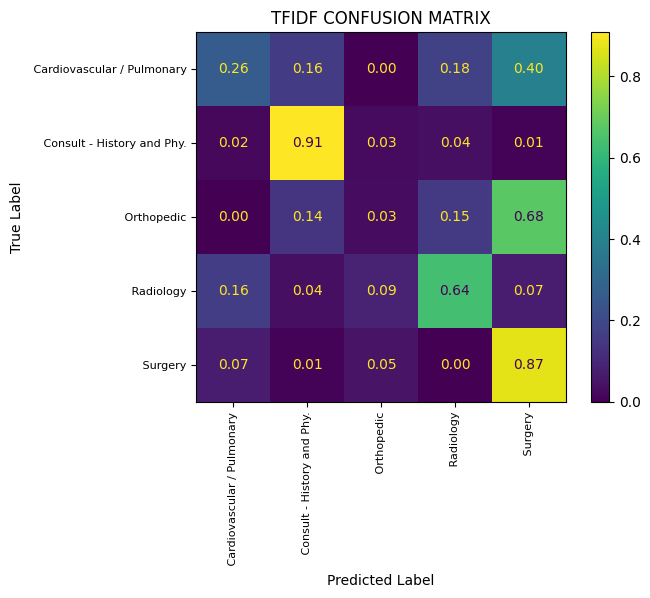

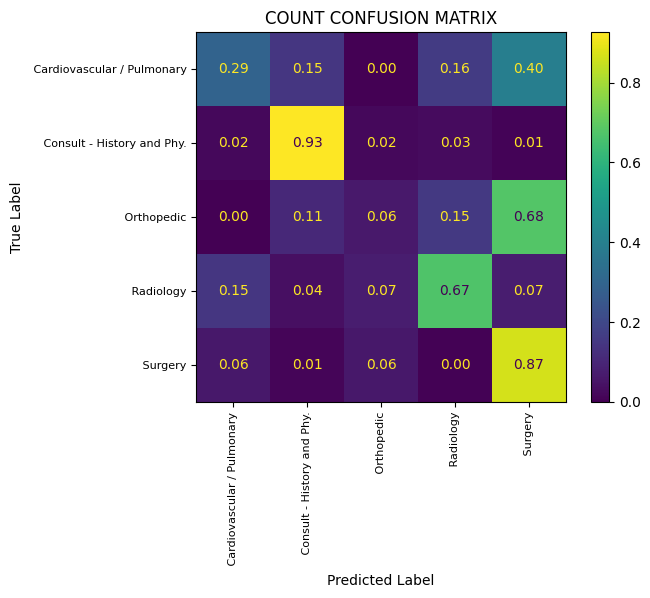

In [9]:
## Question 8

# # HYPERPARAMETER TUNING
# logisticRegressionModelTuning=LogisticRegression()
# param_grid={
#     'C':[0.001,0.01,0.1,1,10,100],
#     'solver':['newton-cg','lbfgs','sag','saga','liblinear']
# }
# gs=GridSearchCV(logisticRegressionModelTuning,param_grid,cv=5,scoring='accuracy',n_jobs=-1)

# # TFIDF HYPERPARAMETER OPTIMIZER
# gs.fit(TFIDFTrainSet,labelTrainSet)
# bestParams=gs.best_params_
# print(bestParams)

# # COUNTING HYPERPARAMETER OPTIMIZER
# gs.fit(countTrainSet,labelTrainSet)
# bestParams=gs.best_params_
# print(bestParams)

## Best hyperparameters based on accuracy found for TFIDF Set
# {'C': 1, 'max_iter': 1000, 'solver': 'liblinear'}
## Best hyperparameters based on accuracy found for Count Set
#{'C': 0.001, 'max_iter': 1000, 'solver': 'liblinear'}

## TFIDF LOGISTIC REGRESSION MODEL
TFIDFLogisticRegressionModel=LogisticRegression(C=1,solver='liblinear')
TFIDFLogisticRegressionModel.fit(TFIDFTrainSet,labelTrainSet)
trainTFIDFPredictions=TFIDFLogisticRegressionModel.predict(TFIDFTrainSet)
TFIDFAccuracy=accuracy_score(trainTFIDFPredictions,labelTrainSet)
print('TFIDF Train Set:',TFIDFAccuracy)
TFIDFPredictions=TFIDFLogisticRegressionModel.predict(TFIDFTestSet)
TFIDFTestAccuracy=accuracy_score(TFIDFPredictions,labelTestSet)
print('TFIDF Test Set Accuracy:',TFIDFTestAccuracy)

## COUNT LOGISTIC REGRESSION MODEL
countLogisticRegressionModel=LogisticRegression(C=0.001,solver='liblinear')
countLogisticRegressionModel.fit(countTrainSet,labelTrainSet)
trainCountPredictions=countLogisticRegressionModel.predict(countTrainSet)
countAccuracy=accuracy_score(trainCountPredictions,labelTrainSet)
print('Count Train Set:',countAccuracy)
countPredictions=countLogisticRegressionModel.predict(countTestSet)
countTestAccuracy=accuracy_score(countPredictions,labelTestSet)
print('Count Test Set Accuracy:',countTestAccuracy)

TFIDFConfusionMatrix=confusion_matrix(labelTestSet,TFIDFPredictions,normalize='true')
countConfusionMatrix=confusion_matrix(labelTestSet,countPredictions,normalize='true')

def ShowConfusionMatrix(confusionMatrix,title):
    # plt.figure(figsize=(10,10))
    # seaborn.heatmap(confusionMatrix,annot=True,fmt='.2f',cmap='Blues')
    # plt.title(title)
    # plt.xlabel('Predicted Label')
    # plt.ylabel('Actual Labels')
    # labels=labelEncode.inverse_transform(range(len(confusionMatrix)))
    # plt.xticks(np.arange(len(labels))+0.5,labels,fontsize=6)
    # plt.yticks(np.arange(len(labels))+0.5,labels,fontsize=6)
    # plt.show()
    
    disp=ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=labels)
    disp.plot(values_format='.2f')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(np.arange(len(labels)),labels,fontsize=8,rotation="vertical")
    plt.yticks(np.arange(len(labels)),labels,fontsize=8)
#print(bothLabels)
ShowConfusionMatrix(TFIDFConfusionMatrix,'TFIDF CONFUSION MATRIX')
ShowConfusionMatrix(countConfusionMatrix,'COUNT CONFUSION MATRIX')
    

# Question 8 Response #

For both count and TF-IDF vectors, both surgery (87% of being correct) and consult - history and phy. (91-93% of being correct) have very accurate predictions. This is followed by radiology, which has a slightly lower percentage of being correctly predicted than surgery and consult. Misclassification probabilities for these classes are generally equal among all other classes, with only slight differences. The only exception is radiology, where it is most commonly incorrectly predicted as cardiovascular/pulmonary.

Orthopedic and cardiovascular/pulmonary is very commonly misclassified as surgery. However, Cardiovascular/Pulmonary generally has a higher correct prediction percentage (correct 26-29% of the time) than orthopedic (correct 3-6% of the time).

TFIDF Best Model (Linear SVM) Accuracy: 0.6756238003838771
Count Best Model (Linear SVM) Accuracy: 0.5335892514395394


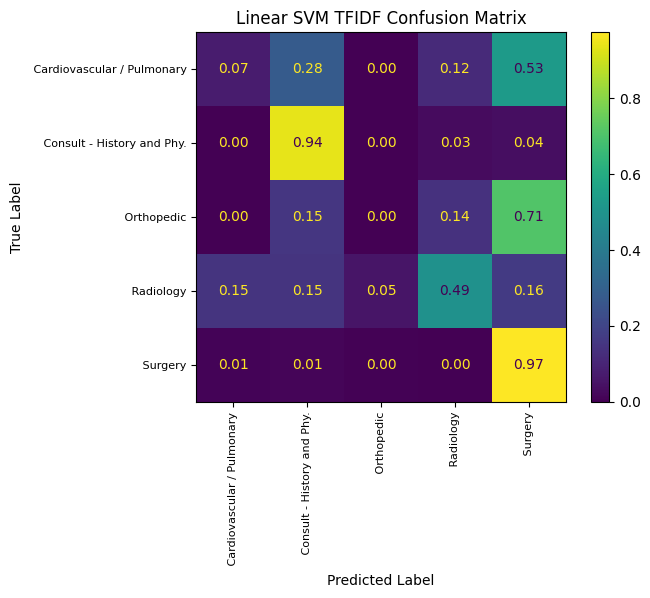

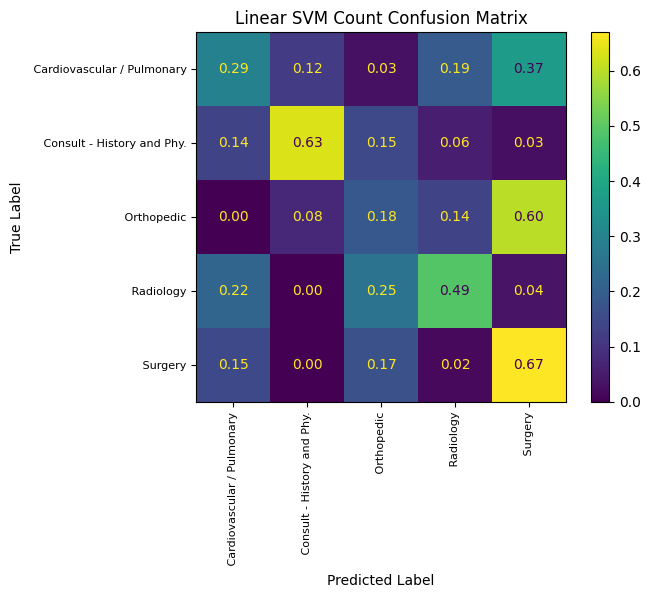

In [10]:
## Question 9

validationTrainSet,validationTestSet=train_test_split(trainData,test_size=0.1,random_state=42)
# countVectorValidation=CountVectorizer()
# TFIDFVectorValidation=TfidfVectorizer()
# countVectorValidation.fit(validationTrainSet['transcription'])
# TFIDFVectorValidation.fit(validationTrainSet['transcription'])

TFIDFTrainSetValidation=TFIDFVector.transform(validationTrainSet['transcription'])
countTrainSetValidation=countVector.transform(validationTrainSet['transcription'])

TFIDFTestSetValidation=TFIDFVector.transform(validationTestSet['transcription'])
countTestSetValidation=countVector.transform(validationTestSet['transcription'])

labelTrainSetValidation=labelEncode.fit_transform(validationTrainSet['medical_specialty'])
labelTestSetValidation=labelEncode.fit_transform(validationTestSet['medical_specialty'])


# print('validation train set',len(validationTrainSet))
# print('validation test set',len(validationTestSet))

## Three classifiers, GaussianNB, RandomForest, and Linear SVM
gaussianModel=GaussianNB()
randomForestModel=RandomForestClassifier()
linearSVMModel=LinearSVC()

##param_grids for each classifier
gaussian_param_grid={
    'var_smoothing':[1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,10,100]
}

forest_param_grid={
    'n_estimators':[50,100,200],
    'max_depth':[None],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4]
}

SVM_param_grid={
    'C':[0.1,1,10,100],
    'loss':['hinge','squared_hinge']
}
# ---GAUSSIAN MODELS---
# bestAccuracyTFIDF=0
# bestParametersTFIDF=None
# bestAccuracyCount=0
# bestParametersCount=None
# for smoothing in gaussian_param_grid['var_smoothing']:
#     modelTFIDF=GaussianNB(var_smoothing=smoothing)
#     modelTFIDF.fit(TFIDFTrainSetValidation.toarray(),labelTrainSetValidation)
    
#     modelCount=GaussianNB(var_smoothing=smoothing)
#     modelCount.fit(countTrainSetValidation.toarray(),labelTrainSetValidation)
    
#     TFIDFPredictionsValidation=modelTFIDF.predict(TFIDFTestSetValidation.toarray())
#     countPredictionsValidation=modelCount.predict(countTestSetValidation.toarray())
    
#     TFIDFAccuracyValidation=accuracy_score(TFIDFPredictionsValidation,labelTestSetValidation)
#     countAccuracyValidation=accuracy_score(countPredictionsValidation,labelTestSetValidation)   
    
#     if TFIDFAccuracyValidation>bestAccuracyTFIDF:
#         bestAccuracyTFIDF=TFIDFAccuracyValidation
#         bestParametersTFIDF={'var_smoothing':smoothing}
#     if countAccuracyValidation>bestAccuracyCount:
#         bestAccuracyCount=countAccuracyValidation
#         bestParametersCount={'var_smoothing':smoothing}
        
# print('best gaussianNB accuracy TFIDF data and parameters:',bestAccuracyTFIDF,':',bestParametersTFIDF)
# print('best gaussianNB accuracy count data and parameters:',bestAccuracyCount,':',bestParametersCount)  


# # ---RANDOM FOREST MODELS---
# bestAccuracyTFIDF=0
# bestParametersTFIDF=None
# bestAccuracyCount=0
# bestParametersCount=None

# for nEstimators in forest_param_grid['n_estimators']:
#     for maxDepth in forest_param_grid['max_depth']:
#         for minSamplesSplit in forest_param_grid['min_samples_split']:
#             for minSamplesLeaf in forest_param_grid['min_samples_leaf']:
#                 modelTFIDF=RandomForestClassifier(n_estimators=nEstimators,max_depth=maxDepth,min_samples_split=minSamplesSplit,min_samples_leaf=minSamplesLeaf)
#                 modelTFIDF.fit(TFIDFTrainSetValidation,labelTrainSetValidation)
                
#                 modelCount=RandomForestClassifier(n_estimators=nEstimators,max_depth=maxDepth,min_samples_split=minSamplesSplit,min_samples_leaf=minSamplesLeaf)
#                 modelCount.fit(countTrainSetValidation,labelTrainSetValidation)
                
#                 TFIDFPredictionsValidation=modelTFIDF.predict(TFIDFTestSetValidation)
#                 countPredictionsValidation=modelCount.predict(countTestSetValidation)
                
#                 TFIDFAccuracyValidation=accuracy_score(TFIDFPredictionsValidation,labelTestSetValidation)
#                 countAccuracyValidation=accuracy_score(countPredictionsValidation,labelTestSetValidation)   
                
#                 if TFIDFAccuracyValidation>bestAccuracyTFIDF:
#                     bestAccuracyTFIDF=TFIDFAccuracyValidation
#                     bestParametersTFIDF={'n_estimators':nEstimators,'max_depth':maxDepth,'min_samples_split':minSamplesLeaf,'min_samples_leaf':minSamplesLeaf}
#                 if countAccuracyValidation>bestAccuracyCount:
#                     bestAccuracyCount=countAccuracyValidation
#                     bestParametersCount={'n_estimators':nEstimators,'max_depth':maxDepth,'min_samples_split':minSamplesLeaf,'min_samples_leaf':minSamplesLeaf}        

# print('best random forest accuracy TFIDF data and parameters:',bestAccuracyTFIDF,':',bestParametersTFIDF)
# print('best random forest accuracy count data and parameters:',bestAccuracyCount,':',bestParametersCount)  


# # ---LINEAR SVM MODELS---
# bestAccuracyTFIDF=0
# bestParametersTFIDF=None
# bestAccuracyCount=0
# bestParametersCount=None

# for c in SVM_param_grid['C']:
#         for lossValue in SVM_param_grid['loss']:
#             modelTFIDF=LinearSVC(C=c,loss=lossValue)
#             modelTFIDF.fit(TFIDFTrainSetValidation,labelTrainSetValidation)
            
#             modelCount=LinearSVC(C=c,loss=lossValue)
#             modelCount.fit(TFIDFTrainSetValidation,labelTrainSetValidation)
            
#             TFIDFPredictionsValidation=modelTFIDF.predict(TFIDFTestSetValidation)
#             countPredictionsValidation=modelCount.predict(countTestSetValidation)
            
#             TFIDFAccuracyValidation=accuracy_score(TFIDFPredictionsValidation,labelTestSetValidation)
#             countAccuracyValidation=accuracy_score(countPredictionsValidation,labelTestSetValidation)   
            
#             if TFIDFAccuracyValidation>bestAccuracyTFIDF:
#                 bestAccuracyTFIDF=TFIDFAccuracyValidation
#                 bestParametersTFIDF={'C':c,'loss':lossValue}
#             if countAccuracyValidation>bestAccuracyCount:
#                 bestAccuracyCount=countAccuracyValidation
#                 bestParametersCount={'C':c,'loss':lossValue}
            
# print('best linear SVM accuracy TFIDF data and parameters:',bestAccuracyTFIDF,':',bestParametersTFIDF)
# print('best linear SVM accuracy count data and parameters:',bestAccuracyCount,':',bestParametersCount) 
       
## Results of all three classifiers

# best gaussianNB accuracy TFIDF data and parameters: 0.6267942583732058 : {'var_smoothing': 0.01}
# best gaussianNB accuracy count data and parameters: 0.5454545454545454 : {'var_smoothing': 1e-05}

# best random forest accuracy TFIDF data and parameters: 0.6411483253588517 : {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 4, 'min_samples_leaf': 4}
# best random forest accuracy count data and parameters: 0.6507177033492823 : {'n_estimators': 50, 'max_depth': None, 'min_samples_split': 4, 'min_samples_leaf': 4}

# best linear SVM accuracy TFIDF data and parameters: 0.6602870813397129 : {'C': 0.1, 'loss': 'hinge'}
# best linear SVM accuracy count data and parameters: 0.6650717703349283 : {'C': 1, 'loss': 'hinge'}

## FINAL MODEL ON TEST DATASET AND CONFUSION MATRIX

bestModelTFIDF=LinearSVC(C=0.1,loss='hinge')
bestModelCount=LinearSVC(C=1,loss='hinge')

bestModelTFIDF.fit(TFIDFTrainSetValidation,labelTrainSetValidation)
bestModelCount.fit(countTrainSetValidation,labelTrainSetValidation)

bestModelPredictionsTFIDF=bestModelTFIDF.predict(TFIDFTestSet)
bestModelPredictionsCount=bestModelCount.predict(countTestSet)

TFIDFAccuracyValidation=accuracy_score(bestModelPredictionsTFIDF,labelTestSet)
countAccuracyValidation=accuracy_score(bestModelPredictionsCount,labelTestSet)

print('TFIDF Best Model (Linear SVM) Accuracy:',TFIDFAccuracyValidation)
print('Count Best Model (Linear SVM) Accuracy:',countAccuracyValidation)

TFIDFConfusionMatrixValidation=confusion_matrix(labelTestSet,bestModelPredictionsTFIDF,normalize='true')
countConfusionMatrixValidation=confusion_matrix(labelTestSet,bestModelPredictionsCount,normalize='true')

ShowConfusionMatrix(TFIDFConfusionMatrixValidation,'Linear SVM TFIDF Confusion Matrix')
ShowConfusionMatrix(countConfusionMatrixValidation,'Linear SVM Count Confusion Matrix')

# Question 9 Response #

For the TF-IDF vectors using the linear SVM, the prediction patterns are generally similar to logstic regression results. Surgery and consult - history and phy are still have the highest percentage of accurate predictions. On one hand, the percentages are even higher in linear SVM (87% to 97% for surgery, and 91% to 94% for consult -history and phy). On the other hand, for radiology, the percentage of accurate predictions decrease in the linear SVM (64% to 49%). Notable changes in misclassifications are that radiology tends to misclassify cardiovascular/pulmonary and consult - history and phy. This is different from the linear regression counterpart, where misclassification mostly occur for cardiovascular/pulmonary only.

For the classes that are generally misclassified, both orthopedic and cardiovascular/pulmonary have less correct predictions (26% to 7% for cardiovascular/pulmonary and 3% to 0% for orthopedic), with more incorrect predictions going to surgery and consult-history and phy. 

For the count vectors, all of the accuracies are generally lower in linear SVM than linear regression. There is a small increase in the correct orthopedic predctions (6% to 8%). However, every other class has less correct predictions for each instance. One notable change is that radiology predicts orthopedic and cardiovascular/pulmonary more than its linear regression counterpart.

In [11]:
## Question 10

## Max of 500 Features
TFIDFVectorizer500Features=TfidfVectorizer(max_features=500,stop_words='english')
  
feature500TrainSetTFIDF=TFIDFVectorizer500Features.fit_transform(trainData['transcription'])
feature500TestSetTFIDF=TFIDFVectorizer500Features.transform(testData['transcription'])

TFIDF500LogisticRegressionModel=LogisticRegression(C=1,max_iter=1000,solver='liblinear')
TFIDF500LogisticRegressionModel.fit(feature500TrainSetTFIDF,labelTrainSet)

TFIDF500Predictions=TFIDF500LogisticRegressionModel.predict(feature500TestSetTFIDF)
accuracy500Predictions=accuracy_score(TFIDF500Predictions,labelTestSet)
print('Logistic Regression Accuracy with 500 Features(TFIDF):',accuracy500Predictions)

topFeatures=TFIDFVectorizer500Features.get_feature_names_out()

#print(topFeatures)
#print(feature500TrainSetTFIDF.shape[1])

## Includes Bi and Trigrams
TFIDFVectorizer500Features=TfidfVectorizer(max_features=500,ngram_range=(2,3),stop_words='english')
  
feature500TrainSetTFIDF=TFIDFVectorizer500Features.fit_transform(trainData['transcription'])
feature500TestSetTFIDF=TFIDFVectorizer500Features.transform(testData['transcription'])

TFIDF500LogisticRegressionModel=LogisticRegression(C=1,max_iter=1000,solver='liblinear')
TFIDF500LogisticRegressionModel.fit(feature500TrainSetTFIDF,labelTrainSet)

TFIDF500Predictions=TFIDF500LogisticRegressionModel.predict(feature500TestSetTFIDF)
accuracy500Predictions=accuracy_score(TFIDF500Predictions,labelTestSet)
print('Logistic Regression Accuracy with 500 Features and Bi/Trigrams (TFIDF):',accuracy500Predictions)

topFeatures=TFIDFVectorizer500Features.get_feature_names_out()

#print(topFeatures)
#print(feature500TrainSetTFIDF.shape[1])

Logistic Regression Accuracy with 500 Features(TFIDF): 0.6871401151631478
Logistic Regression Accuracy with 500 Features and Bi/Trigrams (TFIDF): 0.6487523992322457


# Question 10 Response #

By limiting the features, the accuracy of logistic regression increaases (from 67% to 69%). This is still significantly lower than the training set accuracy, but this is to be expected as it is more difficult to generalize the model. The increase in accuracy could be explained by how limiting the features helped to filter noise, thus increasing model accuracy. This could also be due to the reduced the effects of overfitting, thus allowing the model to generalize better.

However, the model that includes bi/trigrams performed worse (67% to 65%). This could be due to a loss of generalizability due to the bi/trigrams as these n-grams could capture patterns in the training data, but not generalize to unseen data. Furthermore, adding n-grams could lead to redundant features. For example, 'ultrasound' might already indicate a certain class, but 'ultrasound examination' could also have been included. This creates redundant features that might skew the predictions to a certain class. 